#### 작업스케줄링 환경에서 모델을 학습시켜보는 코드입니다.
#### 자세한 사항은 docs/customEnv.md와 scheduler_env/customEnv.py를 참고해주세요

In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

In [2]:
from scheduler_env.customEnv import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

Resource x 8 , Order x 12 환경입니다
다른 환경에서 실험을 진행하고 싶다면 orders, resources 디렉토리를 참고해주세요

혹시 아래에서 오류가 발생할 경우 실행을 한 번 더 눌러주세요

In [7]:
env = SchedulingEnv(machines= "instances/Machines/v0-8.json", jobs = "instances/Jobs/v0-12-deadline.json")
check_env(env)

In [5]:
env2 = SchedulingEnv(machines= "instances/Machines/v0-8.json", jobs = "instances/Jobs/v0-12-deadline.json", weight_final_time = 60, weight_job_deadline = 40, weight_op_rate = 0)
check_env(env2)

아래는 랜덤으로 스케줄링을 진행한 것 입니다.
각 지표의 의미는 customEnv.py 파일을 참고해주세요

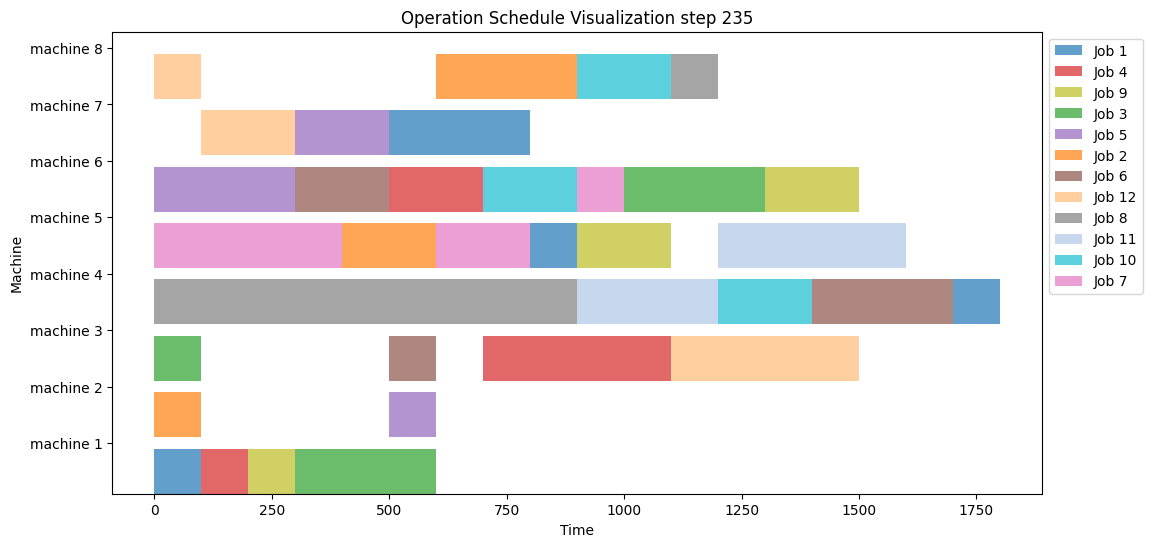

In [8]:
step = 0
obs, info = env.reset()

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        # print("Goal reached!", "final score=", reward)
        # print('finish_time', info['finish_time'])
        # print('order_density', info['order_density'])
        # print('resource_operation_rate', info['resource_operation_rate'])
        # print('order_deadline', info['order_deadline'])
        # print('order_time_exceeded', info['order_time_exceeded'])
        env.render()
        break

PPO 모델을 해당 환경에서 1,000,000 step 만큼 학습시킵니다

In [9]:
model = PPO('MultiInputPolicy', env2, verbose=1).learn(1000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 182      |
|    ep_rew_mean     | -53.6    |
| time/              |          |
|    fps             | 1718     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 192          |
|    ep_rew_mean          | -59.2        |
| time/                   |              |
|    fps                  | 1336         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0146914795 |
|    clip_fraction        | 0.152        |
|    clip_range           | 0.2          |
|    en

Goal reached! final score= 42.76923078298569
finish_time 1300
job_density [1.0, 0.6, 0.7, 1.0, 1.0, 0.75, 0.7777777777777778, 1.0, 1.0, 0.6, 0.5833333333333334, 0.5384615384615384]
machine_operation_rate [0.9230769230769231, 0.6923076923076923, 0.7692307692307693, 0.9230769230769231, 0.8461538461538461, 0.9230769230769231, 0.6153846153846154, 0.46153846153846156]
job_deadline [900, 900, 1050, 1050, 900, 900, 1050, 1500, 750, 900, 1050, 1050]
job_time_exceeded [0, 300, 250, 0, 0, 0, 0, 0, 150, 100, 150, 250]


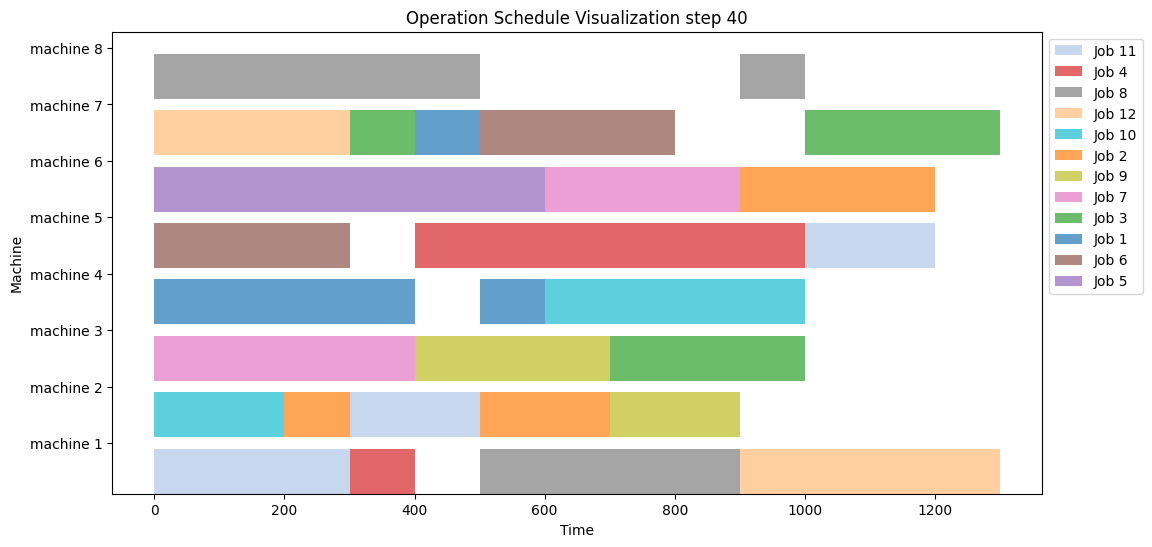

38


In [20]:
obs, info = env2.reset()
done = False
step = 0
while True:
    action, _ = model.predict(obs, deterministic = False)
    obs, reward, terminated, truncated, info = env2.step(action)
    done = terminated or truncated
    step += 1
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('job_density', info['job_density'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        env.render()
        break
print(step)

In [9]:
model.save("PPO_1,000,000_v2")